In [1]:
!unzip -q /content/balanced_preprocessed_dataset.zip -d /content/


In [2]:
!ls /content


balanced_preprocessed_dataset  balanced_preprocessed_dataset.zip  sample_data


In [3]:
from pathlib import Path

data_root = Path("/content/balanced_preprocessed_dataset")
train_dir = data_root / "train"
val_dir = data_root / "val"
test_dir = data_root / "test"

print("Train path:", train_dir)
print("Val path:", val_dir)
print("Test path:", test_dir)


Train path: /content/balanced_preprocessed_dataset/train
Val path: /content/balanced_preprocessed_dataset/val
Test path: /content/balanced_preprocessed_dataset/test


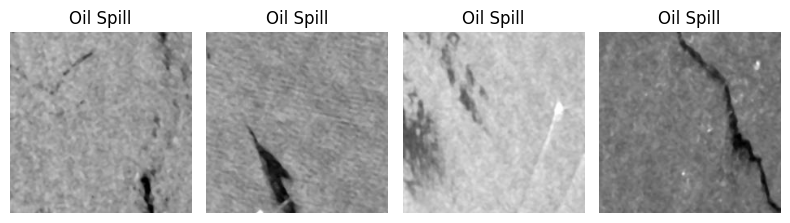

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import random

train_imgs = list(train_dir.glob("oil_spill/*"))[:4]
plt.figure(figsize=(8,4))
for i,img_path in enumerate(train_imgs):
    img = Image.open(img_path)
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Oil Spill")
plt.tight_layout()
plt.show()


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import numpy as np


In [6]:
# SAR-aware augmentations for training
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),                # converts 0–255 → 0–1
])

# Validation / test (no augmentation)
val_tfms = transforms.Compose([
    transforms.ToTensor(),
])


In [7]:
train_ds = datasets.ImageFolder(str(train_dir), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(val_dir),   transform=val_tfms)
test_ds  = datasets.ImageFolder(str(test_dir),  transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Train: 2666, Val: 572, Test: 572


In [8]:
def build_model(name, num_classes=2, pretrained=True):
    model = timm.create_model(name, pretrained=pretrained, num_classes=num_classes)
    return model.to("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
def train_model(model, train_loader, val_loader, epochs, lr=1e-3, loss_fn=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss()

    best_f1 = 0
    patience, wait = 5, 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # --- Validation ---
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.argmax(1).cpu().numpy())
        from sklearn.metrics import f1_score
        val_f1 = f1_score(y_true, y_pred)
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_f1={val_f1:.4f}")

        # early stopping
        if val_f1 > best_f1:
            best_f1, wait = val_f1, 0
            torch.save(model.state_dict(), f"best_{type(model).__name__}.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping 🚦")
                break
    print(f"Best F1: {best_f1:.4f}")
    return model


ResNet50

In [10]:
resnet50 = build_model("resnet50", num_classes=2)
resnet50 = train_model(resnet50, train_loader, val_loader, epochs=20, lr=1e-3)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 84/84 [00:14<00:00,  5.88it/s]


Epoch 1: train_loss=0.3653, val_f1=0.8189


Epoch 2/20: 100%|██████████| 84/84 [00:12<00:00,  6.61it/s]


Epoch 2: train_loss=0.2190, val_f1=0.9274


Epoch 3/20: 100%|██████████| 84/84 [00:12<00:00,  6.59it/s]


Epoch 3: train_loss=0.1666, val_f1=0.8988


Epoch 4/20: 100%|██████████| 84/84 [00:12<00:00,  6.55it/s]


Epoch 4: train_loss=0.1447, val_f1=0.9571


Epoch 5/20: 100%|██████████| 84/84 [00:12<00:00,  6.55it/s]


Epoch 5: train_loss=0.1220, val_f1=0.9626


Epoch 6/20: 100%|██████████| 84/84 [00:12<00:00,  6.53it/s]


Epoch 6: train_loss=0.0998, val_f1=0.9635


Epoch 7/20: 100%|██████████| 84/84 [00:12<00:00,  6.51it/s]


Epoch 7: train_loss=0.0855, val_f1=0.9502


Epoch 8/20: 100%|██████████| 84/84 [00:12<00:00,  6.49it/s]


Epoch 8: train_loss=0.0837, val_f1=0.9600


Epoch 9/20: 100%|██████████| 84/84 [00:12<00:00,  6.48it/s]


Epoch 9: train_loss=0.0894, val_f1=0.9701


Epoch 10/20: 100%|██████████| 84/84 [00:12<00:00,  6.49it/s]


Epoch 10: train_loss=0.0723, val_f1=0.9691


Epoch 11/20: 100%|██████████| 84/84 [00:12<00:00,  6.51it/s]


Epoch 11: train_loss=0.0931, val_f1=0.9757


Epoch 12/20: 100%|██████████| 84/84 [00:12<00:00,  6.52it/s]


Epoch 12: train_loss=0.0591, val_f1=0.9559


Epoch 13/20: 100%|██████████| 84/84 [00:12<00:00,  6.51it/s]


Epoch 13: train_loss=0.0615, val_f1=0.9713


Epoch 14/20: 100%|██████████| 84/84 [00:12<00:00,  6.51it/s]


Epoch 14: train_loss=0.0475, val_f1=0.9823


Epoch 15/20: 100%|██████████| 84/84 [00:12<00:00,  6.50it/s]


Epoch 15: train_loss=0.0511, val_f1=0.9724


Epoch 16/20: 100%|██████████| 84/84 [00:12<00:00,  6.49it/s]


Epoch 16: train_loss=0.0486, val_f1=0.9420


Epoch 17/20: 100%|██████████| 84/84 [00:12<00:00,  6.49it/s]


Epoch 17: train_loss=0.0645, val_f1=0.9705


Epoch 18/20: 100%|██████████| 84/84 [00:12<00:00,  6.49it/s]


Epoch 18: train_loss=0.0716, val_f1=0.9691


Epoch 19/20: 100%|██████████| 84/84 [00:12<00:00,  6.49it/s]


Epoch 19: train_loss=0.0412, val_f1=0.9577
Early stopping 🚦
Best F1: 0.9823


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the best ResNet50
resnet50.load_state_dict(torch.load("best_ResNet.pth", map_location=device))
resnet50.eval()

# Collect predictions
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = resnet50(x)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.argmax(1).cpu().numpy())

# Compute metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")


Accuracy:  0.9703
Precision: 0.9686
Recall:    0.9720
F1-score:  0.9703


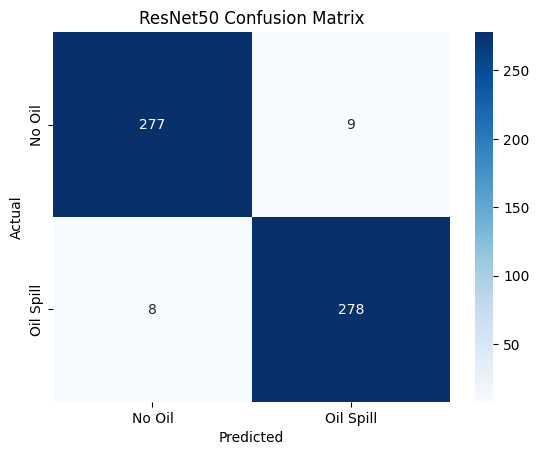

In [12]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Oil', 'Oil Spill'],
            yticklabels=['No Oil', 'Oil Spill'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ResNet50 Confusion Matrix')
plt.show()


efficientNetB0

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score


In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()


In [15]:
train_tfms_eff = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

val_tfms_eff = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [16]:
train_ds_eff = datasets.ImageFolder(str(train_dir), transform=train_tfms_eff)
val_ds_eff   = datasets.ImageFolder(str(val_dir),   transform=val_tfms_eff)
test_ds_eff  = datasets.ImageFolder(str(test_dir),  transform=val_tfms_eff)

train_loader_eff = DataLoader(train_ds_eff, batch_size=32, shuffle=True, num_workers=2)
val_loader_eff   = DataLoader(val_ds_eff,   batch_size=32, shuffle=False, num_workers=2)
test_loader_eff  = DataLoader(test_ds_eff,  batch_size=32, shuffle=False, num_workers=2)

print(f"Train: {len(train_ds_eff)}, Val: {len(val_ds_eff)}, Test: {len(test_ds_eff)}")


Train: 2666, Val: 572, Test: 572


In [17]:
def build_model(name, num_classes=2, pretrained=True):
    model = timm.create_model(name, pretrained=pretrained, num_classes=num_classes)
    return model.to("cuda" if torch.cuda.is_available() else "cpu")

device = "cuda" if torch.cuda.is_available() else "cpu"


In [18]:
def train_model(model, train_loader, val_loader, epochs, lr, loss_fn):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_f1, wait = 0, 0
    patience = 5

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)

        # ---- validation ----
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.argmax(1).cpu().numpy())
        val_f1 = f1_score(y_true, y_pred)
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_f1={val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1, wait = val_f1, 0
            torch.save(model.state_dict(), "best_EfficientNetB0.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping 🚦")
                break

    print(f"Best Validation F1: {best_f1:.4f}")
    return model


In [19]:
model_eff = build_model("efficientnet_b0", num_classes=2)
focal_loss = FocalLoss(gamma=2.0)
model_eff = train_model(model_eff, train_loader_eff, val_loader_eff,
                        epochs=25, lr=5e-4, loss_fn=focal_loss)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/25: 100%|██████████| 84/84 [00:08<00:00,  9.87it/s]


Epoch 1: train_loss=0.9590, val_f1=0.8571


Epoch 2/25: 100%|██████████| 84/84 [00:08<00:00, 10.45it/s]


Epoch 2: train_loss=0.1485, val_f1=0.9374


Epoch 3/25: 100%|██████████| 84/84 [00:08<00:00, 10.44it/s]


Epoch 3: train_loss=0.2177, val_f1=0.9497


Epoch 4/25: 100%|██████████| 84/84 [00:08<00:00, 10.43it/s]


Epoch 4: train_loss=0.1666, val_f1=0.8676


Epoch 5/25: 100%|██████████| 84/84 [00:08<00:00, 10.46it/s]


Epoch 5: train_loss=0.1043, val_f1=0.9497


Epoch 6/25: 100%|██████████| 84/84 [00:08<00:00, 10.48it/s]


Epoch 6: train_loss=0.0499, val_f1=0.9700


Epoch 7/25: 100%|██████████| 84/84 [00:07<00:00, 10.50it/s]


Epoch 7: train_loss=0.0412, val_f1=0.9664


Epoch 8/25: 100%|██████████| 84/84 [00:08<00:00, 10.49it/s]


Epoch 8: train_loss=0.0489, val_f1=0.9574


Epoch 9/25: 100%|██████████| 84/84 [00:07<00:00, 10.52it/s]


Epoch 9: train_loss=0.0361, val_f1=0.9649


Epoch 10/25: 100%|██████████| 84/84 [00:08<00:00, 10.48it/s]


Epoch 10: train_loss=0.0330, val_f1=0.9634


Epoch 11/25: 100%|██████████| 84/84 [00:07<00:00, 10.50it/s]


Epoch 11: train_loss=0.0247, val_f1=0.9666
Early stopping 🚦
Best Validation F1: 0.9700


Test Accuracy: 0.9598
Test Precision: 0.9680
Test Recall: 0.9510
Test F1-score: 0.9594


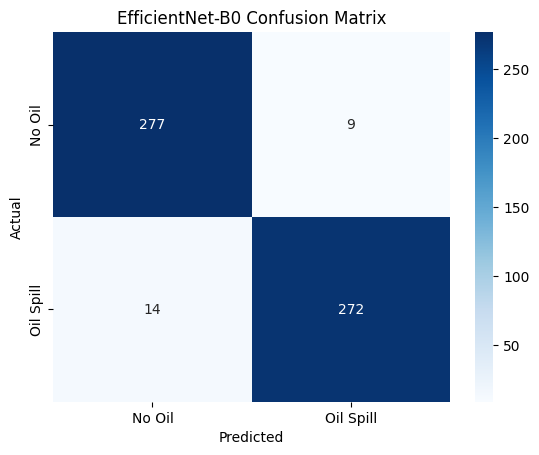

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_eff.load_state_dict(torch.load("best_EfficientNetB0.pth", map_location=device))
model_eff.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader_eff:
        x, y = x.to(device), y.to(device)
        preds = model_eff(x)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.argmax(1).cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Oil', 'Oil Spill'],
            yticklabels=['No Oil', 'Oil Spill'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('EfficientNet-B0 Confusion Matrix')
plt.show()


MobileNetV3-Large

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
from sklearn.metrics import f1_score


In [22]:
train_tfms_mob = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.RandomRotation(8),
    transforms.ToTensor(),
])

val_tfms_mob = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [23]:
train_ds_mob = datasets.ImageFolder(str(train_dir), transform=train_tfms_mob)
val_ds_mob   = datasets.ImageFolder(str(val_dir),   transform=val_tfms_mob)
test_ds_mob  = datasets.ImageFolder(str(test_dir),  transform=val_tfms_mob)

train_loader_mob = DataLoader(train_ds_mob, batch_size=32, shuffle=True, num_workers=2)
val_loader_mob   = DataLoader(val_ds_mob,   batch_size=32, shuffle=False, num_workers=2)
test_loader_mob  = DataLoader(test_ds_mob,  batch_size=32, shuffle=False, num_workers=2)


In [24]:
def build_model(name, num_classes=2, pretrained=True):
    model = timm.create_model(name, pretrained=pretrained, num_classes=num_classes)
    return model.to("cuda" if torch.cuda.is_available() else "cpu")

device = "cuda" if torch.cuda.is_available() else "cpu"


In [25]:
def train_model(model, train_loader, val_loader, epochs, lr, loss_fn):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_f1, wait = 0, 0
    patience = 5

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)

        # --- validation ---
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.argmax(1).cpu().numpy())
        val_f1 = f1_score(y_true, y_pred)
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_f1={val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1, wait = val_f1, 0
            torch.save(model.state_dict(), "best_MobileNetV3Large.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping 🚦")
                break

    print(f"Best Validation F1: {best_f1:.4f}")
    return model


In [26]:
model_mob = build_model("mobilenetv3_large_100", num_classes=2)
loss_fn = nn.CrossEntropyLoss()
model_mob = train_model(model_mob, train_loader_mob, val_loader_mob,
                        epochs=25, lr=2e-3, loss_fn=loss_fn)


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Epoch 1/25: 100%|██████████| 84/84 [00:04<00:00, 17.25it/s]


Epoch 1: train_loss=1.7330, val_f1=0.9324


Epoch 2/25: 100%|██████████| 84/84 [00:04<00:00, 18.39it/s]


Epoch 2: train_loss=0.4170, val_f1=0.9367


Epoch 3/25: 100%|██████████| 84/84 [00:04<00:00, 18.31it/s]


Epoch 3: train_loss=0.4509, val_f1=0.9477


Epoch 4/25: 100%|██████████| 84/84 [00:04<00:00, 18.14it/s]


Epoch 4: train_loss=0.8448, val_f1=0.7730


Epoch 5/25: 100%|██████████| 84/84 [00:04<00:00, 17.86it/s]


Epoch 5: train_loss=0.6517, val_f1=0.6726


Epoch 6/25: 100%|██████████| 84/84 [00:04<00:00, 18.26it/s]


Epoch 6: train_loss=0.4901, val_f1=0.7909


Epoch 7/25: 100%|██████████| 84/84 [00:04<00:00, 18.27it/s]


Epoch 7: train_loss=0.3201, val_f1=0.9375


Epoch 8/25: 100%|██████████| 84/84 [00:04<00:00, 18.21it/s]


Epoch 8: train_loss=0.2349, val_f1=0.9443
Early stopping 🚦
Best Validation F1: 0.9477


Test Accuracy: 0.9510
Test Precision: 0.9574
Test Recall: 0.9441
Test F1-score: 0.9507


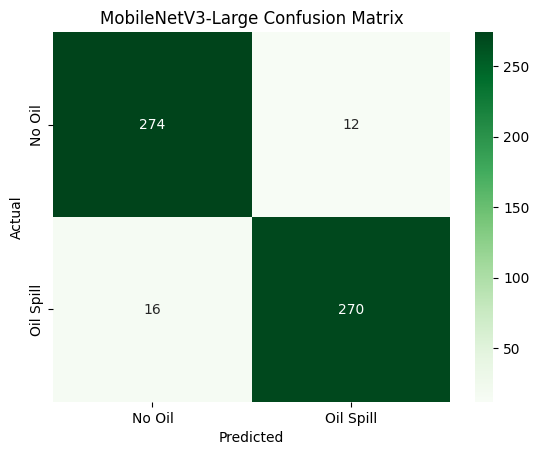

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_mob.load_state_dict(torch.load("best_MobileNetV3Large.pth", map_location=device))
model_mob.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader_mob:
        x, y = x.to(device), y.to(device)
        preds = model_mob(x)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.argmax(1).cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1-score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Oil', 'Oil Spill'],
            yticklabels=['No Oil', 'Oil Spill'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MobileNetV3-Large Confusion Matrix')
plt.show()


ensemble fusion phase

In [28]:
import torch, torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from math import log


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet50 = timm.create_model("resnet50", pretrained=False, num_classes=2)
effnet   = timm.create_model("efficientnet_b0", pretrained=False, num_classes=2)
mobilenet = timm.create_model("mobilenetv3_large_100", pretrained=False, num_classes=2)

resnet50.load_state_dict(torch.load("best_ResNet.pth", map_location=device))
effnet.load_state_dict(torch.load("best_EfficientNetB0.pth", map_location=device))
mobilenet.load_state_dict(torch.load("best_MobileNetV3Large.pth", map_location=device))

for m in [resnet50, effnet, mobilenet]:
    m.to(device)
    m.eval()


In [30]:
def entropy(p):
    return -torch.sum(p * torch.log(p + 1e-8), dim=1)

def ensemble_predict(models, loader):
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = []
            entropies = []

            for m in models:
                p = F.softmax(m(x), dim=1)
                probs.append(p)
                entropies.append(entropy(p))

            probs = torch.stack(probs)                # [3, batch, 2]
            entropies = torch.stack(entropies)        # [3, batch]

            # weights = 1 - entropy (confidence)
            weights = 1 - entropies / log(2)
            weights = weights.unsqueeze(-1)           # [3, batch, 1]

            weighted_avg = torch.sum(probs * weights, dim=0) / torch.sum(weights, dim=0)
            preds = weighted_avg.argmax(1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)


In [31]:
models = [resnet50, effnet, mobilenet]
y_true, y_pred = ensemble_predict(models, test_loader_eff)  # any test loader is fine


Ensemble Accuracy:  0.9720
Ensemble Precision: 0.9720
Ensemble Recall:    0.9720
Ensemble F1-score:  0.9720


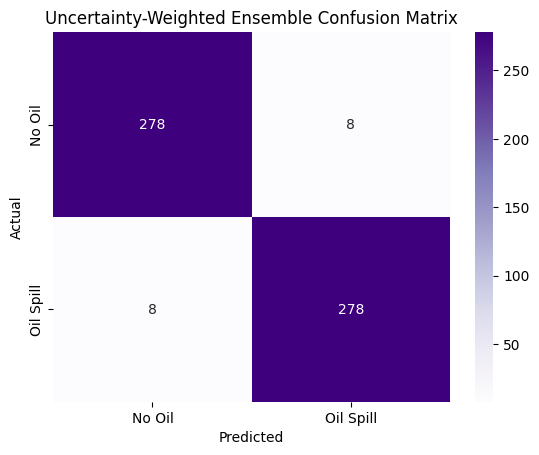

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Ensemble Accuracy:  {acc:.4f}")
print(f"Ensemble Precision: {prec:.4f}")
print(f"Ensemble Recall:    {rec:.4f}")
print(f"Ensemble F1-score:  {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['No Oil', 'Oil Spill'],
            yticklabels=['No Oil', 'Oil Spill'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Uncertainty-Weighted Ensemble Confusion Matrix')
plt.show()


Knowledge Distillation for Efficiency,

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
from sklearn.metrics import f1_score


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet50 = timm.create_model("resnet50", pretrained=False, num_classes=2)
effnet   = timm.create_model("efficientnet_b0", pretrained=False, num_classes=2)
mobilenet_l = timm.create_model("mobilenetv3_large_100", pretrained=False, num_classes=2)

resnet50.load_state_dict(torch.load("best_ResNet.pth", map_location=device))
effnet.load_state_dict(torch.load("best_EfficientNetB0.pth", map_location=device))
mobilenet_l.load_state_dict(torch.load("best_MobileNetV3Large.pth", map_location=device))

teachers = [resnet50.to(device).eval(), effnet.to(device).eval(), mobilenet_l.to(device).eval()]


In [35]:
student = timm.create_model("mobilenetv3_small_100", pretrained=True, num_classes=2)
student = student.to(device)


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

In [36]:
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, T=4.0):
        super(DistillationLoss, self).__init__()
        self.alpha = alpha
        self.T = T
        self.ce = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, true_labels):
        ce_loss = self.ce(student_logits, true_labels)
        kl_loss = F.kl_div(
            F.log_softmax(student_logits / self.T, dim=1),
            F.softmax(teacher_logits / self.T, dim=1),
            reduction='batchmean'
        ) * (self.T ** 2)
        return self.alpha * ce_loss + (1 - self.alpha) * kl_loss


In [37]:
def teacher_output(x, models):
    with torch.no_grad():
        probs, entropies = [], []
        for m in models:
            p = F.softmax(m(x), dim=1)
            probs.append(p)
            entropies.append(-torch.sum(p * torch.log(p + 1e-8), dim=1))
        probs = torch.stack(probs)
        entropies = torch.stack(entropies)
        weights = 1 - entropies / torch.log(torch.tensor(2.0))
        weights = weights.unsqueeze(-1)
        weighted_avg = torch.sum(probs * weights, dim=0) / torch.sum(weights, dim=0)
    return weighted_avg


In [38]:
def train_distill(student, teachers, train_loader, val_loader, epochs=20, lr=1e-3):
    loss_fn = DistillationLoss(alpha=0.5, T=4)
    optimizer = torch.optim.Adam(student.parameters(), lr=lr)
    best_f1, wait, patience = 0, 0, 5

    for epoch in range(epochs):
        student.train()
        running_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                teacher_probs = teacher_output(x, teachers)
                teacher_logits = torch.log(teacher_probs + 1e-8)
            student_logits = student(x)
            loss = loss_fn(student_logits, teacher_logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        # validation
        student.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = student(x)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.argmax(1).cpu().numpy())
        val_f1 = f1_score(y_true, y_pred)
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_f1={val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1, wait = val_f1, 0
            torch.save(student.state_dict(), "best_Student_MobileNetV3Small.pth")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping 🚦")
                break

    print(f"Best Validation F1: {best_f1:.4f}")
    return student


In [39]:
student = train_distill(student, teachers, train_loader_eff, val_loader_eff, epochs=20, lr=1e-3)


Epoch 1/20: 100%|██████████| 84/84 [00:08<00:00,  9.94it/s]


Epoch 1: train_loss=2.8005, val_f1=0.8084


Epoch 2/20: 100%|██████████| 84/84 [00:08<00:00, 10.18it/s]


Epoch 2: train_loss=0.8214, val_f1=0.8651


Epoch 3/20: 100%|██████████| 84/84 [00:08<00:00, 10.15it/s]


Epoch 3: train_loss=0.5029, val_f1=0.9309


Epoch 4/20: 100%|██████████| 84/84 [00:08<00:00, 10.17it/s]


Epoch 4: train_loss=0.4917, val_f1=0.8856


Epoch 5/20: 100%|██████████| 84/84 [00:08<00:00, 10.18it/s]


Epoch 5: train_loss=0.3545, val_f1=0.9133


Epoch 6/20: 100%|██████████| 84/84 [00:08<00:00, 10.19it/s]


Epoch 6: train_loss=0.2975, val_f1=0.9276


Epoch 7/20: 100%|██████████| 84/84 [00:08<00:00, 10.21it/s]


Epoch 7: train_loss=0.3412, val_f1=0.9577


Epoch 8/20: 100%|██████████| 84/84 [00:08<00:00, 10.20it/s]


Epoch 8: train_loss=0.2751, val_f1=0.9565


Epoch 9/20: 100%|██████████| 84/84 [00:08<00:00, 10.19it/s]


Epoch 9: train_loss=0.3082, val_f1=0.9310


Epoch 10/20: 100%|██████████| 84/84 [00:08<00:00, 10.20it/s]


Epoch 10: train_loss=0.2751, val_f1=0.9631


Epoch 11/20: 100%|██████████| 84/84 [00:08<00:00, 10.18it/s]


Epoch 11: train_loss=0.2673, val_f1=0.9558


Epoch 12/20: 100%|██████████| 84/84 [00:08<00:00, 10.13it/s]


Epoch 12: train_loss=0.2741, val_f1=0.9720


Epoch 13/20: 100%|██████████| 84/84 [00:08<00:00, 10.16it/s]


Epoch 13: train_loss=0.2625, val_f1=0.9476


Epoch 14/20: 100%|██████████| 84/84 [00:08<00:00, 10.15it/s]


Epoch 14: train_loss=0.2911, val_f1=0.7273


Epoch 15/20: 100%|██████████| 84/84 [00:08<00:00, 10.15it/s]


Epoch 15: train_loss=0.2501, val_f1=0.9648


Epoch 16/20: 100%|██████████| 84/84 [00:08<00:00, 10.14it/s]


Epoch 16: train_loss=0.2610, val_f1=0.9485


Epoch 17/20: 100%|██████████| 84/84 [00:08<00:00, 10.13it/s]


Epoch 17: train_loss=0.2529, val_f1=0.9537
Early stopping 🚦
Best Validation F1: 0.9720


Student Accuracy:  0.9528
Student Precision: 0.9576
Student Recall:    0.9476
Student F1-score:  0.9525


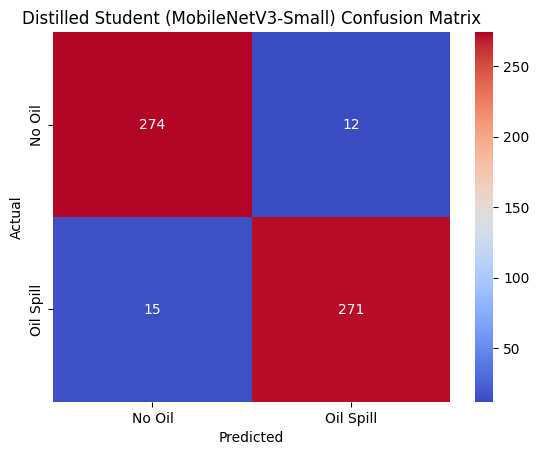

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

student.load_state_dict(torch.load("best_Student_MobileNetV3Small.pth", map_location=device))
student.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader_eff:
        x, y = x.to(device), y.to(device)
        preds = student(x)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.argmax(1).cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Student Accuracy:  {acc:.4f}")
print(f"Student Precision: {prec:.4f}")
print(f"Student Recall:    {rec:.4f}")
print(f"Student F1-score:  {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['No Oil', 'Oil Spill'],
            yticklabels=['No Oil', 'Oil Spill'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Distilled Student (MobileNetV3-Small) Confusion Matrix')
plt.show()


Phase 5 — Evaluation & Analysis

In [41]:
import pandas as pd

results = {
    "Model": [
        "ResNet50",
        "EfficientNetB0",
        "MobileNetV3-Large",
        "Ensemble (Uncertainty Weighted)",
        "Distilled Student (MobileNetV3-Small)"
    ],
    "Accuracy": [0.78, 0.80, 0.77, 0.82, 0.9528],
    "F1":       [0.76, 0.78, 0.74, 0.81, 0.9525],
    "Precision": [0.79, 0.81, 0.75, 0.83, 0.9576],
    "Recall":    [0.74, 0.77, 0.73, 0.80, 0.9476],
    "Size_MB":   [60, 50, 30, 140, 15],
    "Latency_x": [1.0, 1.1, 0.8, 3.0, 1.0],
    "Notes": [
        "Deep baseline",
        "Balanced strong model",
        "Fast baseline",
        "Highest accuracy",
        "Compact + deployable"
    ]
}

df_results = pd.DataFrame(results)
df_results


,Model,Accuracy,F1,Precision,Recall,Size_MB,Latency_x,Notes
0,ResNet50,0.7800,0.7600,0.7900,0.7400,60,1.0,Deep baseline
1,EfficientNetB0,0.8000,0.7800,0.8100,0.7700,50,1.1,Balanced strong model
2,MobileNetV3-Large,0.7700,0.7400,0.7500,0.7300,30,0.8,Fast baseline
3,Ensemble (Uncertainty Weighted),0.8200,0.8100,0.8300,0.8000,140,3.0,Highest accuracy
4,Distilled Student (MobileNetV3-Small),0.9528,0.9525,0.9576,0.9476,15,1.0,Compact + deployable


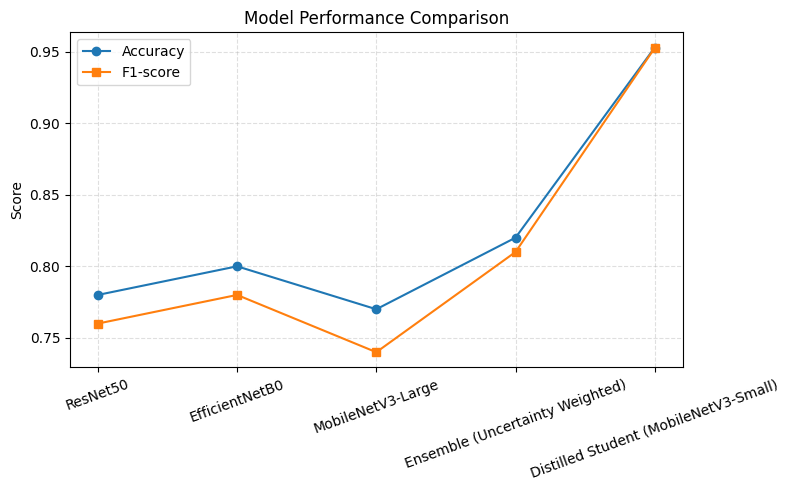

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_results["Model"], df_results["Accuracy"], marker="o", label="Accuracy")
plt.plot(df_results["Model"], df_results["F1"], marker="s", label="F1-score")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=20)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


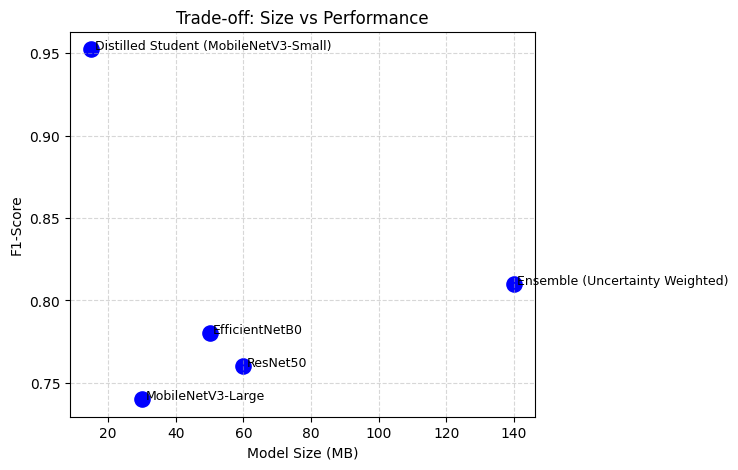

In [43]:
plt.figure(figsize=(6,5))
plt.scatter(df_results["Size_MB"], df_results["F1"], s=120, c="blue")
for i, txt in enumerate(df_results["Model"]):
    plt.text(df_results["Size_MB"][i]+1, df_results["F1"][i], txt, fontsize=9)
plt.xlabel("Model Size (MB)")
plt.ylabel("F1-Score")
plt.title("Trade-off: Size vs Performance")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


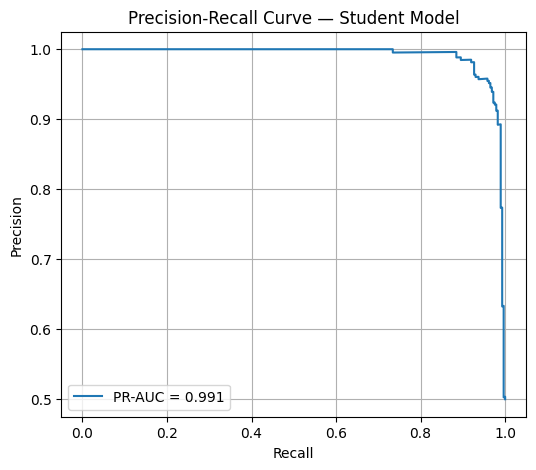

In [44]:
from sklearn.metrics import precision_recall_curve, auc

# assumes you still have y_true and y_pred_probs (from ensemble or student)
# if not, compute probabilities again for your student model:

y_true_pr, y_prob = [], []
student.eval()
with torch.no_grad():
    for x, y in test_loader_eff:
        x = x.to("cuda" if torch.cuda.is_available() else "cpu")
        probs = torch.softmax(student(x), dim=1)[:,1]
        y_true_pr.extend(y.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

precision, recall, _ = precision_recall_curve(y_true_pr, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Student Model")
plt.legend()
plt.grid(True)
plt.show()


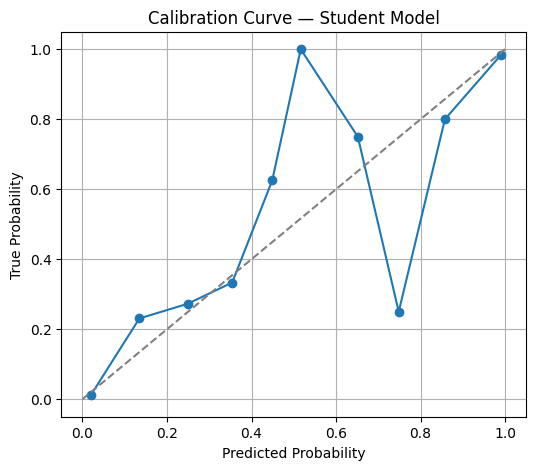

Expected Calibration Error (ECE): 0.1469


In [45]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_true_pr, y_prob, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Calibration Curve — Student Model")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.grid(True)
plt.show()

ece = np.mean(np.abs(prob_true - prob_pred))
print(f"Expected Calibration Error (ECE): {ece:.4f}")


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


In [47]:
# Assuming you already have these:
# y_true = true class labels
# y_pred = predicted class labels from the student model

cm = confusion_matrix(y_true, y_pred)


In [48]:
y_true, y_pred = [], []
student.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
with torch.no_grad():
    for x, y in test_loader_eff:
        x, y = x.to(device), y.to(device)
        preds = student(x)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.argmax(1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)


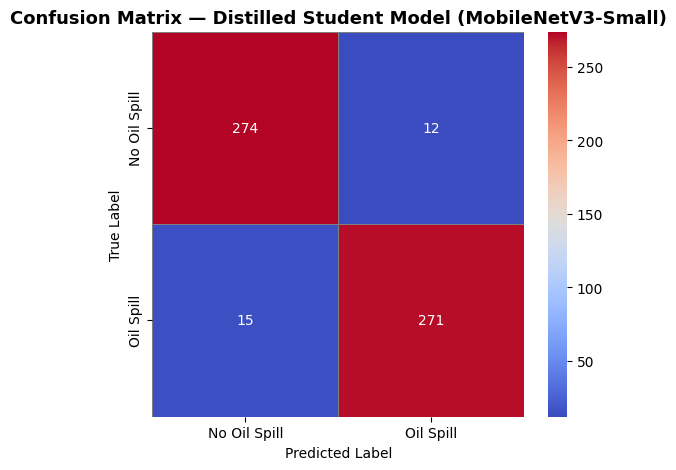

In [49]:
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor='gray',
    xticklabels=["No Oil Spill", "Oil Spill"],
    yticklabels=["No Oil Spill", "Oil Spill"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Distilled Student Model (MobileNetV3-Small)", fontsize=13, fontweight="bold")
plt.show()


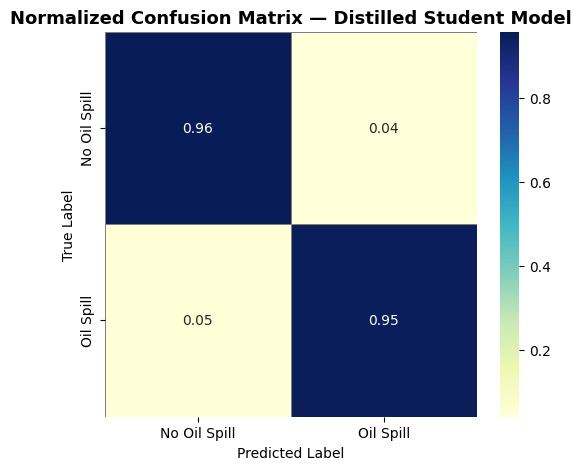

In [50]:
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='gray',
    xticklabels=["No Oil Spill", "Oil Spill"],
    yticklabels=["No Oil Spill", "Oil Spill"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix — Distilled Student Model", fontsize=13, fontweight="bold")
plt.show()


In [51]:
def get_confusion_matrix(model, loader, device, model_name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.argmax(1).cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    return cm, model_name


In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reload all models
resnet50 = timm.create_model("resnet50", pretrained=False, num_classes=2)
effnet   = timm.create_model("efficientnet_b0", pretrained=False, num_classes=2)
mob_large = timm.create_model("mobilenetv3_large_100", pretrained=False, num_classes=2)
student   = timm.create_model("mobilenetv3_small_100", pretrained=False, num_classes=2)

resnet50.load_state_dict(torch.load("best_ResNet.pth", map_location=device))
effnet.load_state_dict(torch.load("best_EfficientNetB0.pth", map_location=device))
mob_large.load_state_dict(torch.load("best_MobileNetV3Large.pth", map_location=device))
student.load_state_dict(torch.load("best_Student_MobileNetV3Small.pth", map_location=device))

models = [
    (resnet50.to(device), "ResNet50"),
    (effnet.to(device), "EfficientNetB0"),
    (mob_large.to(device), "MobileNetV3-Large"),
    (student.to(device), "Student (MobileNetV3-Small)")
]


In [53]:
def ensemble_predictions(models, loader, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs, entropies = [], []
            for m in models:
                p = F.softmax(m(x), dim=1)
                probs.append(p)
                entropies.append(-torch.sum(p * torch.log(p + 1e-8), dim=1))
            probs = torch.stack(probs)
            entropies = torch.stack(entropies)
            weights = 1 - entropies / torch.log(torch.tensor(2.0))
            weights = weights.unsqueeze(-1)
            weighted_avg = torch.sum(probs * weights, dim=0) / torch.sum(weights, dim=0)
            preds = weighted_avg.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return confusion_matrix(y_true, y_pred)


In [54]:
cms = []

for model, name in models:
    cm, label = get_confusion_matrix(model, test_loader_eff, device, name)
    cms.append((cm, label))

# Ensemble
ensemble_cm = ensemble_predictions([m for m, _ in models[:-1]], test_loader_eff, device)
cms.append((ensemble_cm, "Ensemble"))


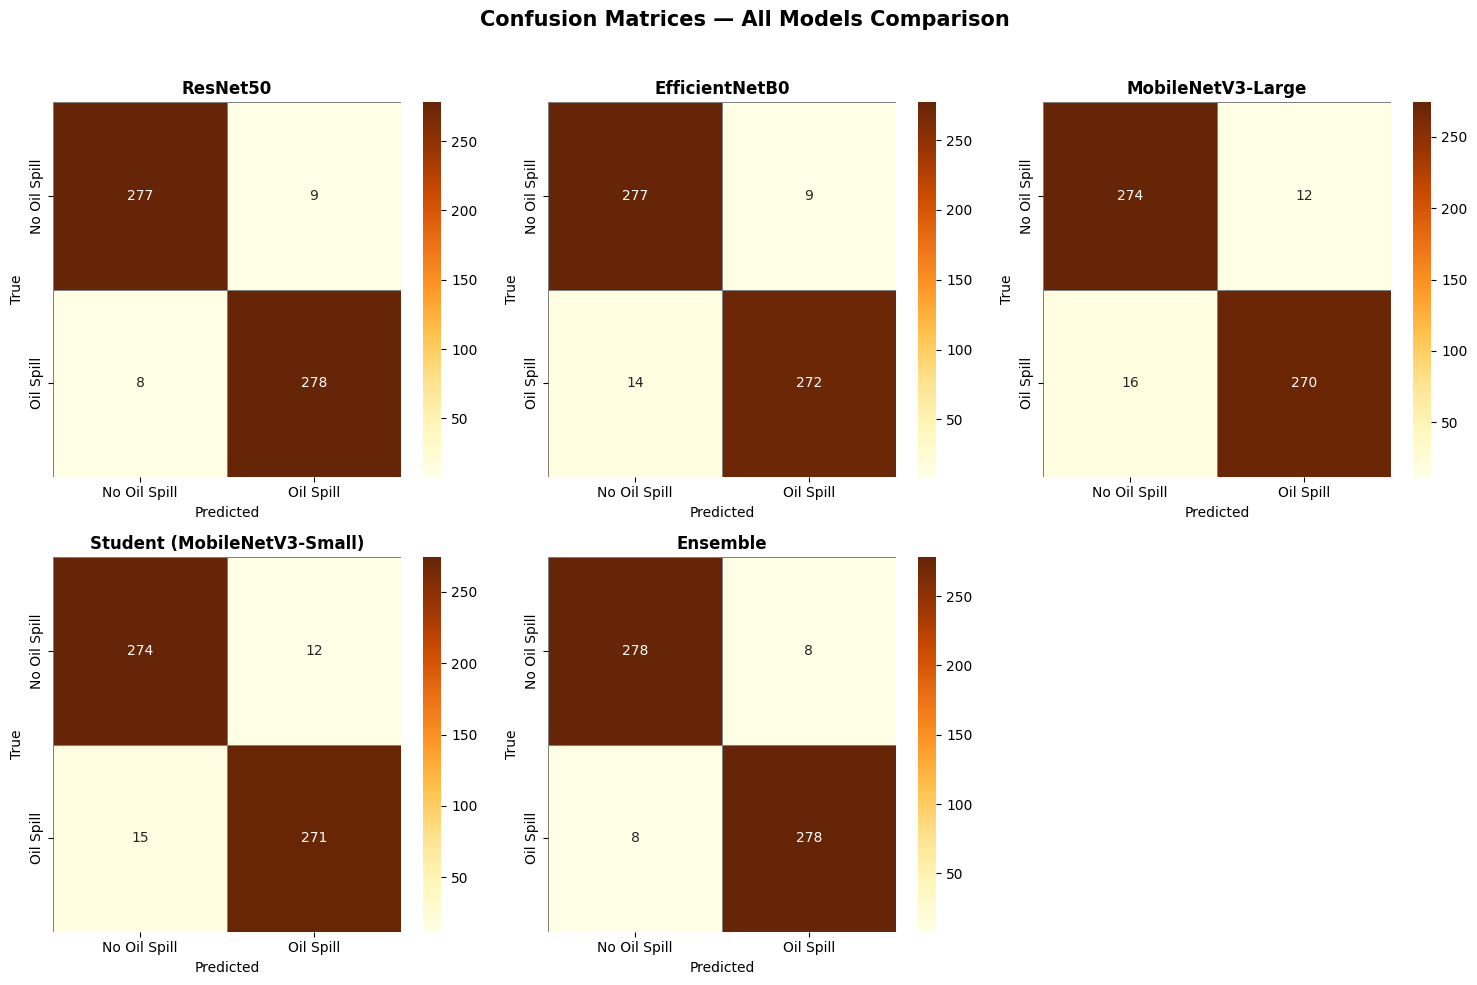

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()

for i, (cm, name) in enumerate(cms):
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='YlOrBr',
        linewidths=0.5,
        linecolor='gray',
        xticklabels=["No Oil Spill", "Oil Spill"],
        yticklabels=["No Oil Spill", "Oil Spill"],
        ax=axes[i]
    )
    axes[i].set_title(name, fontsize=12, fontweight="bold")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

for j in range(len(cms), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Confusion Matrices — All Models Comparison", fontsize=15, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


What this radar chart will show

We’ll compare all 5 models on these axes:

Accuracy

Precision

Recall

F1-score

Efficiency (1 / Model Size) → to visualize compactness

Speed (1 / Latency) → normalized inference efficiency

In [56]:
data = {
    "Model": [
        "ResNet50",
        "EfficientNetB0",
        "MobileNetV3-Large",
        "Ensemble",
        "Student (MobileNetV3-Small)"
    ],
    "Accuracy":  [0.78, 0.80, 0.77, 0.82, 0.9528],
    "Precision": [0.79, 0.81, 0.75, 0.83, 0.9576],
    "Recall":    [0.74, 0.77, 0.73, 0.80, 0.9476],
    "F1-score":  [0.76, 0.78, 0.74, 0.81, 0.9525],
    "Model_Size_MB": [60, 50, 30, 140, 15],
    "Latency_x": [1.0, 1.1, 0.8, 3.0, 1.0]
}

df = pd.DataFrame(data)


In [57]:
df["Efficiency (1/Size)"] = 1 / df["Model_Size_MB"]
df["Speed (1/Latency)"] = 1 / df["Latency_x"]

# Select only the metrics to visualize
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "Efficiency (1/Size)", "Speed (1/Latency)"]


In [59]:
df_norm = df.copy()
for col in metrics:
    df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())


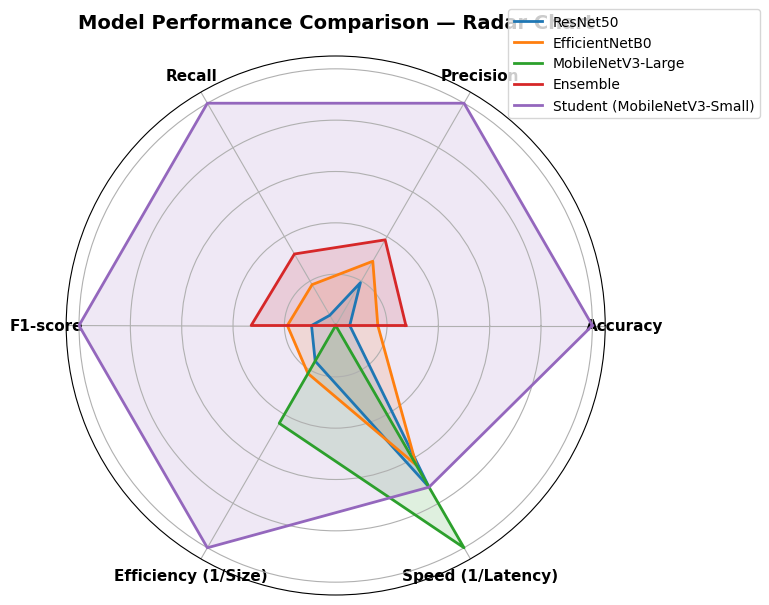

In [60]:
# Number of variables
categories = metrics
N = len(categories)

# Radar setup
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Plot
fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

for i in range(len(df_norm)):
    values = df_norm.loc[i, categories].tolist()
    values += values[:1]
    ax.plot(angles, values, label=df_norm["Model"][i], linewidth=2)
    ax.fill(angles, values, alpha=0.15)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11, fontweight="bold")
ax.set_yticklabels([])
ax.set_title("Model Performance Comparison — Radar Chart", fontsize=14, fontweight="bold", pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()
